This analysis uses a dataset from the National Oceanic and Atmospheric Administration's [National Centers for Environmental Information](https://www.ngdc.noaa.gov/) about 658 significant volcanic eruptions that occurred between 4360 BCE and 2014 CE. 

Using SQLite, pandas and matplotlib in Jupyter Notebooks, I identify the most active volcanoes in this period; the countries which experienced the most volcanic activity; the eras with the greatest number of volcanic eruptions; and the impact these volcanoes have had in terms of human lives lost and damage done.

The original dataset can be downloaded [here](https://public.tableau.com/s/sites/default/files/media/Resources/significantvolcanoeruptions.xlsx).

## Set up

### Define functions

In [1]:
#@title
import tempfile
from urllib import request
import sqlite3

from typing import Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

#%load_ext google.colab.data_table

# Set float display options for pandas dataframes.
pd.options.display.float_format = "{:,.2f}".format

def excel_dataset_to_sqlite(url: str, database_name: str = ":memory:") -> sqlite3.Connection:
  """Downloads an excel dataset and loads it into an sqlite database."""

  # Download the data into a local variable.
  data = request.urlopen(url).read()

  # Write it out to afiles
  with tempfile.TemporaryFile() as fle:
    fle.write(data)

    # Read into pandas from excel file.
    data = pd.read_excel(fle, sheet_name=None)

  # Create a database.
  conn = sqlite3.connect(database_name)

  # Loads data from pandas objects into individual tables.
  for (key, sheet) in data.items():
    sheet = sheet.where(pd.notnull(sheet), None)
    sheet.to_sql(key, conn)


  # Return database.
  return conn

### Prepare the data

#### Import the dataset and create the database

The data comes from the NOAA's National Centers for Environmental Information. It's an Excel file with one sheet of data about volcanic eruptions. 

I download the file from this [URL](https://public.tableau.com/s/sites/default/files/media/Resources/significantvolcanoeruptions.xlsx), and convert it into an SQL database to enable analysis in Jupyter Notebooks.

In [2]:
database = excel_dataset_to_sqlite("https://public.tableau.com/s/sites/default/files/media/Resources/significantvolcanoeruptions.xlsx")

/Users/Matthew/Library/Caches/pypoetry/virtualenvs/notebooks-IW0Gw3EE-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


Once the database has been created, I change some of the column names to make the data easier to work with. The first row of data is empty, so I also remove it.

In [3]:
#@title
database.execute("""
    Alter Table volerup
    Rename Column `Associated Tsunami?` To Associated_Tsunami;""")

database.execute("""
    Alter Table volerup
    Rename Column `Associated Earthquake?` To Associated_Earthquake;""")

database.execute("""
    Alter Table volerup
    Rename Column `Volcano Explosivity Index (VEI)` To VEI;""")

database.execute("""DELETE FROM volerup
                    WHERE Year IS NULL;""")

## Understand the database

There are 658 rows in the data. The data covers 234 volcanoes in 73 locations across 48 countries. There are also 8 distinct values assigned to Volcanic Explosivity Index.

In [4]:
pd.read_sql("""SELECT COUNT(DISTINCT Name) AS Volcano_Name,
                      COUNT(DISTINCT Location) AS Location,
                      COUNT(DISTINCT Country) AS Country,
                      COUNT(DISTINCT VEI) AS VEI
               FROM volerup;""", database)

,Volcano_Name,Location,Country,VEI
0,234,73,48,8


## Where do volcanic eruptions happen?

Let's start by identifying the geographical location of these volcanic eruptions.

Indonesia has the highest number of volcanoes, as well as the highest number of volcanic incidents.

In [5]:
result = pd.read_sql("""SELECT Country, 
                        COUNT(DISTINCT Name) AS Volcanos_Per_Country
                        FROM volerup
                        GROUP BY Country
                        ORDER BY COUNT(DISTINCT Name) DESC
                        LIMIT 20;""", database)

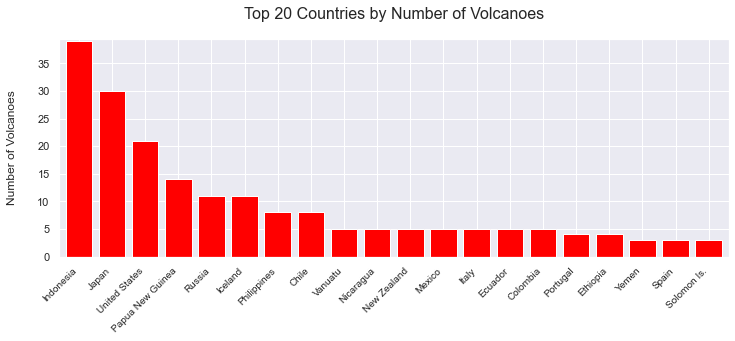

In [6]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Volcanos_Per_Country"], color='red')
plt.title("Top 20 Countries by Number of Volcanoes", pad = 20, fontsize = 16)
plt.ylabel("Number of Volcanoes", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

In [7]:
result = pd.read_sql("""SELECT Country, 
                        COUNT(Country) AS Incidents_Per_Country 
                        FROM volerup
                        GROUP BY Country
                        ORDER BY COUNT(Country) DESC
                        LIMIT 20;""", database)

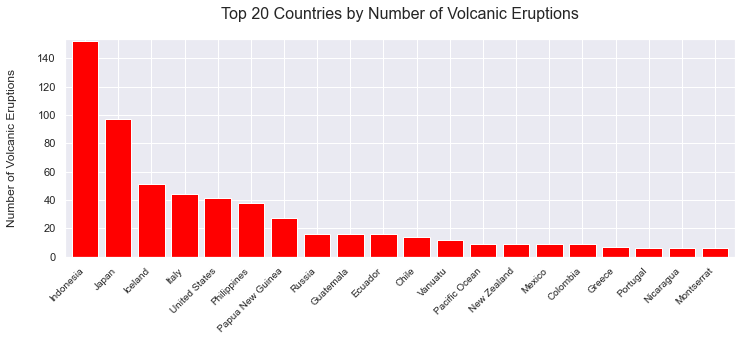

In [8]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Incidents_Per_Country"], color='red')
plt.title("Top 20 Countries by Number of Volcanic Eruptions", pad = 20, fontsize = 16)
plt.ylabel("Number of Volcanic Eruptions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

However, Italy's volcanoes experience the highest number of eruptions per volcano.

In [9]:
pd.read_sql("""
    SELECT Country, 
           COUNT(Country) AS Incidents_Per_Country, 
           COUNT(DISTINCT Name) AS Volcanos_Per_Country,
           CAST(COUNT(Country) AS REAL) / COUNT(DISTINCT Name) AS Incidents_Per_Volcano
    FROM volerup
    GROUP BY Country
    ORDER BY CAST(COUNT(Country) AS REAL) / COUNT(DISTINCT Name) DESC
    LIMIT 20;""", database)

,Country,Incidents_Per_Country,Volcanos_Per_Country,Incidents_Per_Volcano
0,Italy,44,5,8.80
1,Greece,7,1,7.00
2,Montserrat,6,1,6.00
3,Guatemala,16,3,5.33
4,Comoros,5,1,5.00
5,Philippines,38,8,4.75
6,Iceland,51,11,4.64
7,Martinique,4,1,4.00
8,Indonesia,152,39,3.90
9,Japan,97,30,3.23


Mount Etna in Italy is the single most active volcano in the dataset, with 19 incidents. 

In [10]:
result = pd.read_sql("""
    SELECT Name, 
           Location, 
           Country, 
           COUNT(Name) AS Number_of_Incidents
    FROM volerup
    GROUP BY Name
    ORDER BY COUNT(Name) DESC
    LIMIT 20;""", database)          

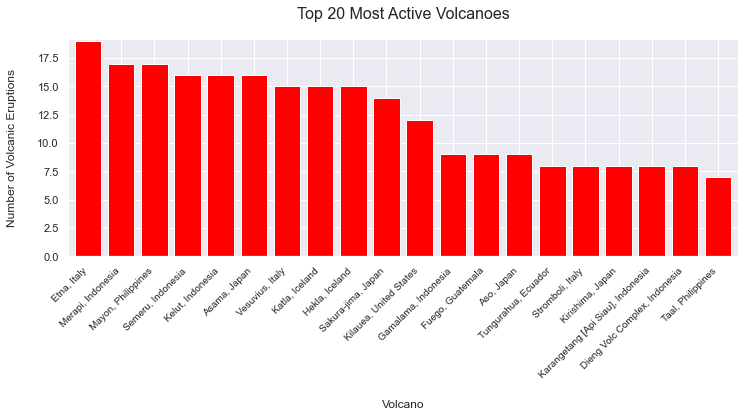

In [11]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Name"] + ", " + result["Country"], height=result["Number_of_Incidents"], color='red')
plt.title("Top 20 Most Active Volcanoes", pad = 20, fontsize = 16)
plt.xlabel("Volcano", labelpad=20)
plt.ylabel("Number of Volcanic Eruptions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

### Indonesia

Let's have a more detailed look at Indonesia, the country with the highest number of volcanoes and volcanic eruptions.

We can look at the regions in Indonesia to see which are the most volcanically active. Java is the most volcanic region in Indonesia, with 13 volcanoes and 76 incidents.

In [12]:
result = pd.read_sql("""
    SELECT Location, 
           COUNT(DISTINCT Name) AS Number_of_Volcanoes, 
           COUNT(Location) AS Number_of_Incidents
    FROM volerup
    WHERE Country = 'Indonesia'
    GROUP BY Location
    ORDER BY COUNT(Location) DESC;""", database)

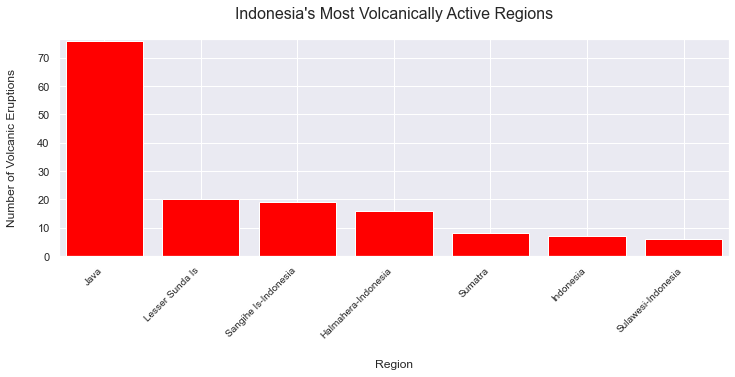

In [13]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Location"], height=result["Number_of_Incidents"], color='red')
plt.title("Indonesia's Most Volcanically Active Regions", pad = 20, fontsize = 16)
plt.xlabel("Region", labelpad=20, fontsize = 12)
plt.ylabel("Number of Volcanic Eruptions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

The dataset includes the [Volcanic Explosivity Index (VEI)](https://en.wikipedia.org/wiki/Volcanic_Explosivity_Index) figure for each eruption. The VEI measures the relative explosiveness of an eruption, with 0 (non-explosive) being the smallest possible value, and 8 the largest.

The majority of Indonesia's volcanic eruptions sit on this lower end of this scale, with most being a 2 or 3 on the scale.

In [14]:
result = pd.read_sql("""SELECT COUNT(Name) AS Number_of_Incidents,
                               CAST(VEI AS INT) AS VEI
                        FROM volerup
                        WHERE Country = 'Indonesia'
                        GROUP BY VEI
                        ORDER BY VEI ASC;""", database)

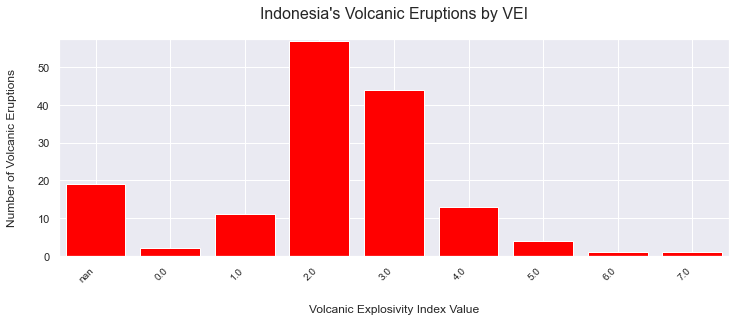

In [15]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["VEI"].astype(str), height=result["Number_of_Incidents"], color='red')
plt.title("Indonesia's Volcanic Eruptions by VEI", pad = 20, fontsize = 16)
plt.xlabel("Volcanic Explosivity Index Value", labelpad=20, fontsize = 12)
plt.ylabel("Number of Volcanic Eruptions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## When did these eruptions happen?

The data covers the period from 4360 BCE to 2014 CE. 

Were there any centuries in this timespan that were particularly affected by volcanic eruptions?

The period between 1000 CE and 2000 CE has the highest number of recorded volcanic incidents. The availability of data regarding the volcanic incidents is dependent on humans' ability to record and measure this activity, so it should not be a surprise that we have more information about the most recent volcanic eruptions than about the ones which occurred centuries or millennia ago.

In [16]:
result = pd.read_sql("""
  SELECT COUNT(Name),
         CASE 
            WHEN Year >= -5000 AND Year < -4001 THEN "5th Millennium BCE"
            WHEN Year >= -4000 AND Year < -3001 THEN "4th Millennium BCE"
            WHEN Year >= -3000 AND Year < -2001 THEN "3rd Millennium BCE"
            WHEN Year >= -2000 AND Year < -1001 THEN "2nd Millennium BCE"
            WHEN Year >= -1000 AND Year <= 0 THEN "1st Millennium BCE"
            WHEN Year > 0 AND Year <= 1000 THEN "1st Millennium CE"
            WHEN Year > 1000 AND Year <= 2000 THEN "2nd Millennium CE"
            WHEN Year > 2000 AND Year <= 3000 THEN "3rd Millennium CE"
         END Century 
  FROM volerup
  GROUP BY Century
  ORDER BY 
          CASE 
             WHEN Century = "5th Millennium BCE" THEN 1
             WHEN Century = "4th Millennium BCE" THEN 2
             WHEN Century = "3rd Millennium BCE" THEN 3
             WHEN Century = "2nd Millennium BCE" THEN 4
             WHEN Century = "1st Millennium BCE" THEN 5
             WHEN Century = "1st Millennium CE" THEN 6
             WHEN Century = "2nd Millennium CE" THEN 7
             WHEN Century = "3rd Millennium CE" THEN 8
           END;""", database)
result

,COUNT(Name),Century
0,3,5th Millennium BCE
1,3,4th Millennium BCE
2,1,3rd Millennium BCE
3,10,2nd Millennium BCE
4,6,1st Millennium BCE
5,25,1st Millennium CE
6,552,2nd Millennium CE
7,58,3rd Millennium CE


We can look at the data for 1000 CE to 2000 CE in more detail.

We saw above that there are more data points for the period 1001 CE to 2000 CE than for any millennium. This pattern is seen again in the individual centuries which made up this millennium, as we have a steady increase in the number of data points as the centuries progress. 

In [17]:
result = pd.read_sql("""SELECT COUNT(Name),
               CASE 
                    WHEN Year >= 1001 AND Year <= 1100 THEN "11th Century CE"
                    WHEN Year >= 1101 AND Year <= 1200 THEN "12th Century CE"
                    WHEN Year >= 1201 AND Year <= 1300 THEN "13th Century CE"
                    WHEN Year >= 1301 AND Year <= 1400 THEN "14th Century CE"
                    WHEN Year >= 1401 AND Year <= 1500 THEN "15th Century CE"
                    WHEN Year >= 1501 AND Year <= 1600 THEN "16th Century CE"
                    WHEN Year >= 1601 AND Year <= 1700 THEN "17th Century CE"
                    WHEN Year >= 1701 AND Year <= 1800 THEN "18th Century CE"
                    WHEN Year >= 1801 AND Year <= 1900 THEN "19th Century CE"
                    WHEN Year >= 1901 AND Year <= 2000 THEN "20th Century CE"
               END Century 
               FROM volerup
               WHERE Year >= 1001 AND Year <=2000
               GROUP BY Century
               ORDER BY Century;""", database)

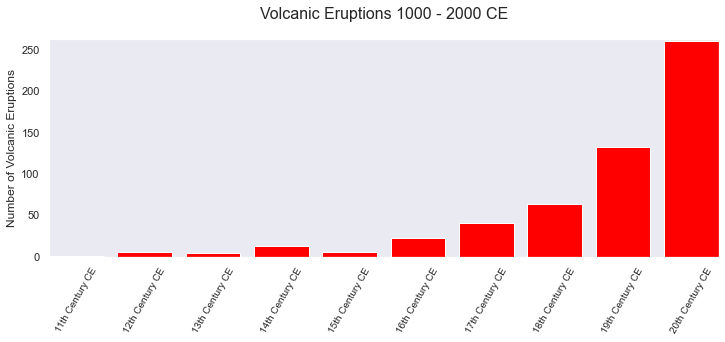

In [18]:
plt.figure(figsize=(12, 4))
plt.grid(False)
plt.bar(x=result["Century"].astype(str), height=result["COUNT(Name)"], color = "red")
plt.title("Volcanic Eruptions 1000 - 2000 CE", pad = 20, fontsize = 16)
plt.ylabel("Number of Volcanic Eruptions", fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "center", fontsize = 10)
plt.margins(0.00, 0.01)

The 20th century saw 260 recorded volcanic incidents. Let's have a look at those incidents in more detail. 

1902 was the most active year in the twentieth century, with 8 volcanic incidents.

In [19]:
result = pd.read_sql("""
    SELECT CAST(Year AS INTEGER) AS Year, 
           COUNT(Year) AS Number_of_Incidents
    FROM volerup
    WHERE Year >= 1901 AND Year <= 2000
    GROUP BY Year          
    ORDER BY Year ASC;""", database)

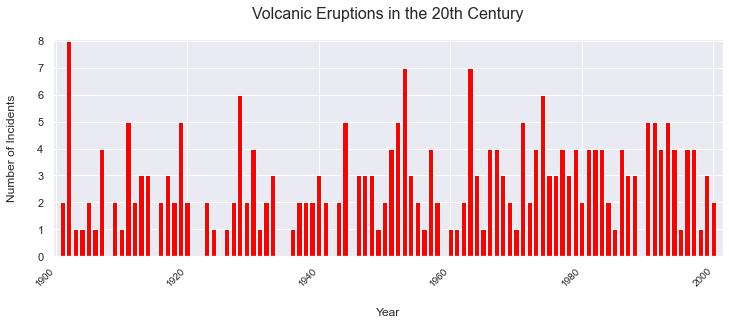

In [20]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Year"], height=result["Number_of_Incidents"], color='red')
plt.title("Volcanic Eruptions in the 20th Century", pad = 20, fontsize = 16)
plt.xlabel("Year", labelpad=20, fontsize = 12)
plt.ylabel("Number of Incidents", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

The highest number of twentieth-century volcanic eruptions occurred in Indonesia. This is not surprising, as we know from above that Indonesia had the highest number of volcanic incidents overall, as well as the largest number of volcanoes.

In [21]:
result = pd.read_sql("""SELECT Country, 
                               COUNT(Country) AS Number_of_Incidents
                        FROM volerup
                        WHERE Year >= 1901 AND Year <= 2000
                        GROUP BY Country
                        ORDER BY COUNT(Country) DESC
                        LIMIT 20;""", database)

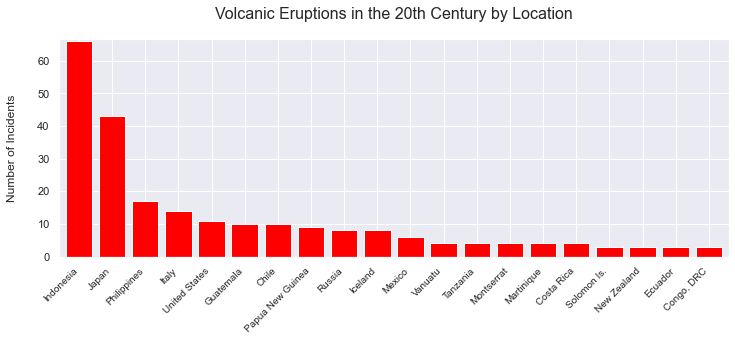

In [22]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Number_of_Incidents"], color='red')
plt.title("Volcanic Eruptions in the 20th Century by Location", pad = 20, fontsize = 16)
plt.ylabel("Number of Incidents", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Impact - Fatalities

For many of the incidents covered in the database, we have figures for the number of people killed. Which volcanos have killed the most people?

In [23]:
result = pd.read_sql("""SELECT DISTINCT(Name), 
                               Country, 
                               SUM(Deaths) AS Total_Deaths
                        FROM volerup
                        WHERE Deaths NOTNULL
                        GROUP BY Name
                        ORDER BY SUM(Deaths) DESC
                        LIMIT 20;""", database)

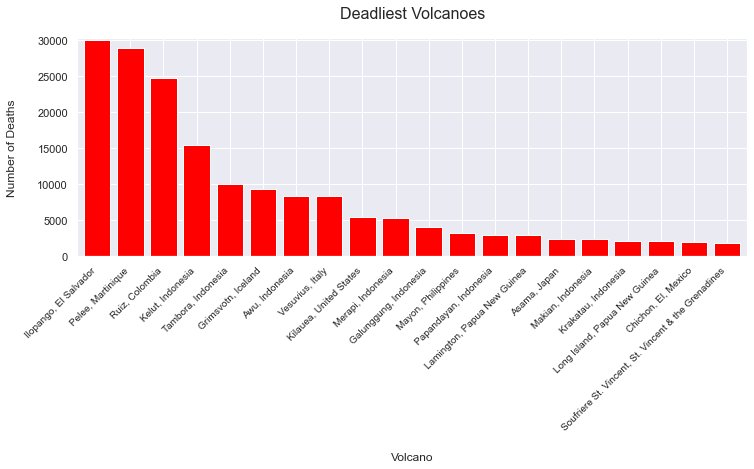

In [24]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Name"] + ", " + result["Country"], height=result["Total_Deaths"], color='red')
plt.title("Deadliest Volcanoes", pad = 20, fontsize = 16)
plt.xlabel("Volcano", labelpad=20, fontsize = 12)
plt.ylabel("Number of Deaths", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

And which country suffered the greatest death toll from volcanic incidents?

In [25]:
result = pd.read_sql("""SELECT Country, 
                               SUM(Deaths) AS Total_Deaths
                        FROM volerup
                        WHERE Deaths NOTNULL
                        GROUP BY Country
                        ORDER BY SUM(Deaths) DESC
                        LIMIT 20;""", database)

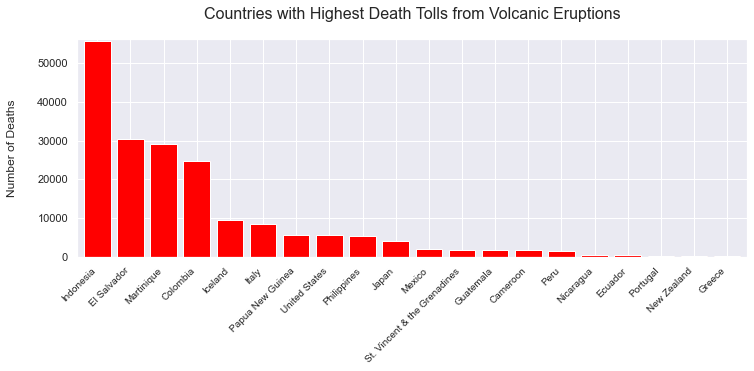

In [26]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Total_Deaths"], color='red')
plt.title("Countries with Highest Death Tolls from Volcanic Eruptions", pad = 20, fontsize = 16)
plt.ylabel("Number of Deaths", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

And which year was the deadliest?

In [27]:
result = pd.read_sql("""SELECT CAST(Year AS INTEGER) AS Year, 
                               COUNT(Name) AS Number_of_Incidents, 
                               SUM(Deaths) AS Total_Deaths
                        FROM volerup
                        WHERE Deaths NOTNULL
                        GROUP BY Year
                        ORDER BY Year ASC
                        LIMIT 20;""", database)

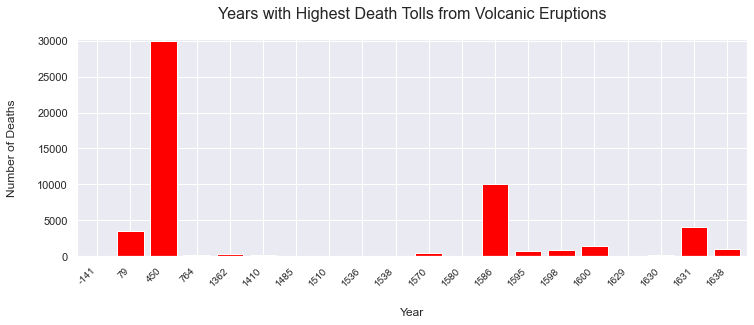

In [28]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Year"].astype(str), height=result["Total_Deaths"], color='red')
plt.title("Years with Highest Death Tolls from Volcanic Eruptions", pad = 20, fontsize = 16)
plt.xlabel("Year", labelpad=20, fontsize = 12)
plt.ylabel("Number of Deaths", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Impact - Financial Cost

Which volcanic incidents did the most damage?

Although the query limits search results to 20, only 10 records in the database have a dollar value for damages. 

The eruption of St Helens in 1980 is the most damaging incident in the dataset.

In [29]:
result = pd.read_sql("""
    SELECT Name, 
           Country, 
           CAST(Year AS INTEGER) AS Year, 
           CAST(SUM(TOTAL_DAMAGE_MILLIONS_DOLLARS) AS INTEGER) AS 'Total Damage ($m)'
    FROM volerup
    WHERE TOTAL_DAMAGE_MILLIONS_DOLLARS NOTNULL
    GROUP BY TOTAL_DAMAGE_MILLIONS_DOLLARS
    ORDER BY SUM(TOTAL_DAMAGE_MILLIONS_DOLLARS) DESC
    LIMIT 20;""", database)

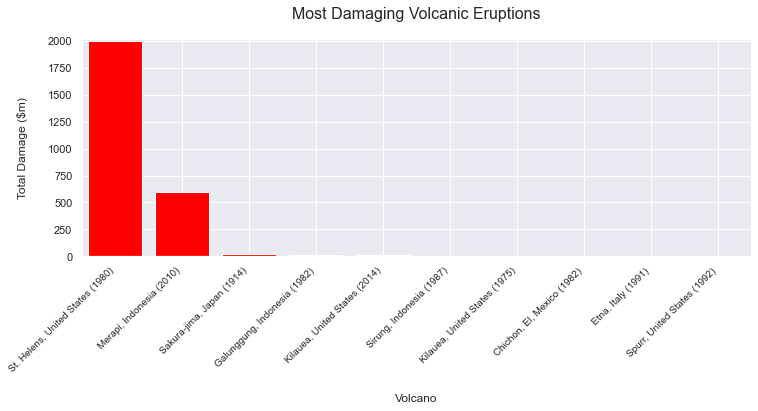

In [30]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Name"] + ", " + result["Country"] + " (" + result["Year"].astype(str) + ")", height=result["Total Damage ($m)"], color='red')
plt.title("Most Damaging Volcanic Eruptions", pad = 20, fontsize = 16)
plt.xlabel("Volcano", labelpad=20, fontsize = 12)
plt.ylabel("Total Damage ($m)", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Impact - Destructiveness

We can also find out how many homes were destroyed by each incident.

In [31]:
result = pd.read_sql("""
 SELECT Name,  
        Country, 
        CAST(Year AS INTEGER) AS Year, 
        CAST(SUM(TOTAL_HOUSES_DESTROYED) AS INTEGER) AS Houses_Destroyed
 FROM volerup
 WHERE TOTAL_HOUSES_DESTROYED NOTNULL
 GROUP BY TOTAL_HOUSES_DESTROYED
 ORDER BY SUM(TOTAL_HOUSES_DESTROYED) DESC
 LIMIT 20;""", database)

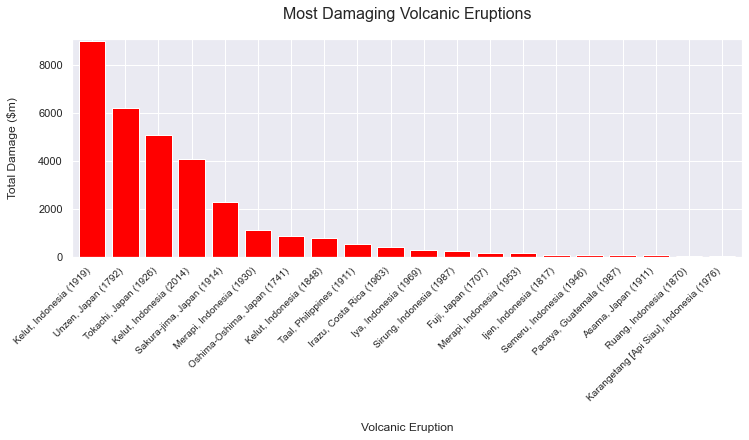

In [32]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Name"] + ", " + result["Country"] + " (" + result["Year"].astype(str) + ")", height=result["Houses_Destroyed"], color='red')
plt.title("Most Damaging Volcanic Eruptions", pad = 20, fontsize = 16)
plt.xlabel("Volcanic Eruption", labelpad=20, fontsize = 12)
plt.ylabel("Total Damage ($m)", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Associated Phenomena - Tsunamis and Earthquakes

The dataset also records where these volcanic eruptions are linked to tsunamis or earthquakes. How many of the eruptions are associated with tsunamis or earthquakes, and which countries are the most affected?

### Tsunamis

Of the 658 incidents recorded in the dataset, 133 are linked to tsunamis.

Indonesia faced the highest number of volcano-related tsunamis. This is not surprising given its high number of volcanoes, and its geography -- Indonesia consists of more than 17,000 islands.

In [33]:
result = pd.read_sql("""
   SELECT Country, 
          COUNT(Country) AS Number_of_Tsunamis
   FROM volerup
   WHERE Associated_Tsunami = "TSU"
   GROUP BY Country
   ORDER BY COUNT(Country) DESC;""", database)

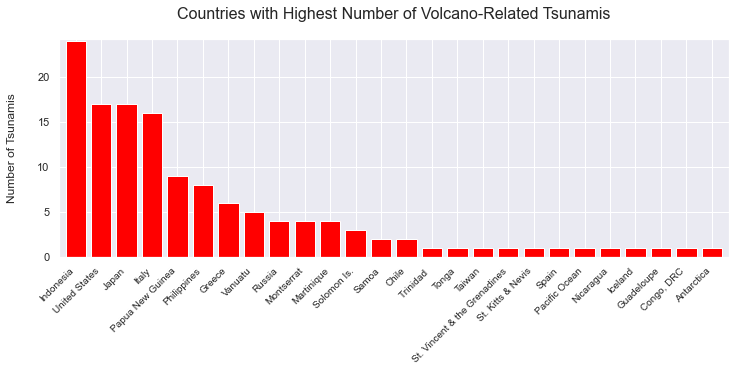

In [34]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Number_of_Tsunamis"], color='red')
plt.title("Countries with Highest Number of Volcano-Related Tsunamis", pad = 20, fontsize = 16)
plt.ylabel("Number of Tsunamis", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

### Earthquakes

Fewer volcanis eruptions are linked to earthquakes than to tsunamis. 55 of the eruptions in the dataset have an associated earthquake.

The United States and Japan are the two countries most affected by volcano-related earthquakes. 

In [35]:
result = pd.read_sql("""
     SELECT Country, 
            COUNT(Country) AS Number_of_Earthquakes
     FROM volerup
     WHERE Associated_Earthquake = "EQ"
     GROUP BY Country
     ORDER BY COUNT(Country) DESC;""", database)

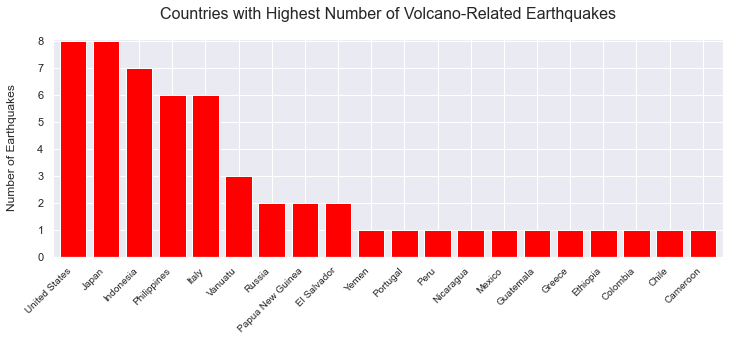

In [36]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Country"], height=result["Number_of_Earthquakes"], color='red')
plt.title("Countries with Highest Number of Volcano-Related Earthquakes", pad = 20, fontsize = 16)
plt.ylabel("Number of Earthquakes", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

And what about volcanic eruptions linked to tsunamis and earthquakes?

36 incidents in the dataset were linked to both an earthquake and a tsunami.

In [37]:
pd.read_sql("""
    SELECT Name,
           Country,
           COUNT(Name)
    FROM volerup
    WHERE Associated_Earthquake = "EQ" AND Associated_Tsunami = "TSU"
    GROUP BY Name
    ORDER BY COUNT(Name) DESC;""", database)

,Name,Country,COUNT(Name)
0,Taal,Philippines,4
1,Yasur,Vanuatu,2
2,Sakura-jima,Japan,2
3,Mauna Loa,United States,2
4,Etna,Italy,2
5,Westdahl,United States,1
6,Vesuvius,Italy,1
7,Unzen,Japan,1
8,Umboi,Papua New Guinea,1
9,St. Helens,United States,1
